# 0.0 Imports

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import sklearn.preprocessing as pp
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import pickle as pkl
import requests

## 0.1 Datasets

In [2]:
features = pd.read_csv('../data/raw/features.csv')
stores = pd.read_csv('../data/raw/stores.csv')
train = pd.read_csv('../data/raw/train.csv')

## 0.2 Helper Functions

In [3]:
def search_outliers(df, col):
    first = np.percentile(df[col], 25)
    second = np.percentile(df[col], 50)
    third = np.percentile(df[col], 75)
    range_ = third - first
    jump = range_ * 1.5
    ls = third + jump
    li = first - jump
    df = df.loc[(df[col]>=li)&(df[col]<=ls)]
    return df

# 1.0 Data Description

## 1.1 Looking Datasets

In [4]:
features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [5]:
stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [6]:
train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


## 1.2 Data Dimension

In [7]:
train.shape

(421570, 5)

In [8]:
stores.shape

(45, 3)

In [9]:
features.shape

(8190, 12)

## 1.3 Change Column Names

In [10]:
temp = []
for i in features.columns:
    temp.append(i.lower())
features.columns = temp

In [11]:
temp = []
for i in stores.columns:
    temp.append(i.lower())
stores.columns = temp

In [12]:
temp = []
for i in train.columns:
    temp.append(i.lower())
train.columns = temp

## 1.4 Merging Data

In [13]:
df = train.merge(features.drop('isholiday', axis=1), on=['store', 'date'], how='left')

df = df.merge(stores, on='store', how='left')

In [14]:
df.head()

,store,dept,date,weekly_sales,isholiday,temperature,fuel_price,markdown1,markdown2,markdown3,markdown4,markdown5,cpi,unemployment,type,size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,A,151315
4,1,1,2010-03-05,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,A,151315


## 1.5 Check Na

In [15]:
df.isna().sum() / df.shape[0] 

store           0.000000
dept            0.000000
date            0.000000
weekly_sales    0.000000
isholiday       0.000000
temperature     0.000000
fuel_price      0.000000
markdown1       0.642572
markdown2       0.736110
markdown3       0.674808
markdown4       0.679847
markdown5       0.640790
cpi             0.000000
unemployment    0.000000
type            0.000000
size            0.000000
dtype: float64

## 1.6 Removing Nas

In [16]:
df.drop('markdown1 markdown2 markdown3 markdown4 markdown5'.split(), axis=1, inplace=True)

In [17]:
df_raw = df.copy()

In [18]:
df.head()

,store,dept,date,weekly_sales,isholiday,temperature,fuel_price,cpi,unemployment,type,size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,211.096358,8.106,A,151315
1,1,1,2010-02-12,46039.49,True,38.51,2.548,211.242170,8.106,A,151315
2,1,1,2010-02-19,41595.55,False,39.93,2.514,211.289143,8.106,A,151315
3,1,1,2010-02-26,19403.54,False,46.63,2.561,211.319643,8.106,A,151315
4,1,1,2010-03-05,21827.90,False,46.50,2.625,211.350143,8.106,A,151315


## 1.7 Datatypes

In [19]:
df.dtypes

store             int64
dept              int64
date             object
weekly_sales    float64
isholiday          bool
temperature     float64
fuel_price      float64
cpi             float64
unemployment    float64
type             object
size              int64
dtype: object

## 1.8 Changing Datatypes

In [20]:
df['date'] = pd.to_datetime(df['date'])

df['isholiday'] = df['isholiday'].astype(int)

In [21]:
df['type'].value_counts()

type
A    215478
B    163495
C     42597
Name: count, dtype: int64

In [22]:
df['type'] = df['type'].apply(lambda x: 0 if x == 'A' else (1 if x == 'B' else 2))

## 1.9 Descriptive Statistical

### 1.9.1 Numerical Attributes

In [23]:
num_attributes = 'weekly_sales temperature fuel_price cpi unemployment size'.split()
cat_attributes = 'store dept isholiday type'.split()

In [32]:
def descriptive_statistical(df, col):
    a = df[col].mean()
    b = df[col].median()
    c = np.abs(df[col].mean() - df[col].median()) / df[col].mean()
    d = df[col].std()
    e = df[col].min()
    f = df[col].max()
    g = df[col].max() - df[col].min()
    h = df[col].std() / df[col].mean() * 100
    i = df[col].skew()
    j = df[col].kurtosis()
    k = np.percentile(df[col], 25)
    l = np.percentile(df[col], 50)
    m = np.percentile(df[col], 75)

    temp = pd.DataFrame([a, b, c, d, e, f, g, h, i, j, k, l, m], index='mean median desloc std min max range coef_disper skew kurtosis 1_quartil 2_quartil 3_quartil'.split(), columns=[col])
    temp = round(temp, 2)
    return temp

def plot_descriptive_statistical(df, col):
    if col == 'weekly_sales':
        temp = search_outliers(df, col)
        fig, ax = plt.subplots(1, 3, figsize=(20, 3))
        sns.histplot(data=temp, x=col, ax=ax[0])
        sns.boxplot(data=temp, x=col, ax=ax[1]);
    else:
        temp = search_outliers(df, col)
        fig, ax = plt.subplots(1, 3, figsize=(20, 3))
        sns.histplot(data=temp, x=col, ax=ax[0])
        sns.boxplot(data=temp, x=col, ax=ax[1])
        sns.scatterplot(data=temp, x=col, y='weekly_sales', ax=ax[2]);

,mean,median,desloc,std,min,max,range,coef_disper,skew,kurtosis,1_quartil,2_quartil,3_quartil
temperature,60.09,62.09,0.03,18.45,-2.06,100.14,102.2,30.7,-0.32,-0.64,46.68,62.09,74.28


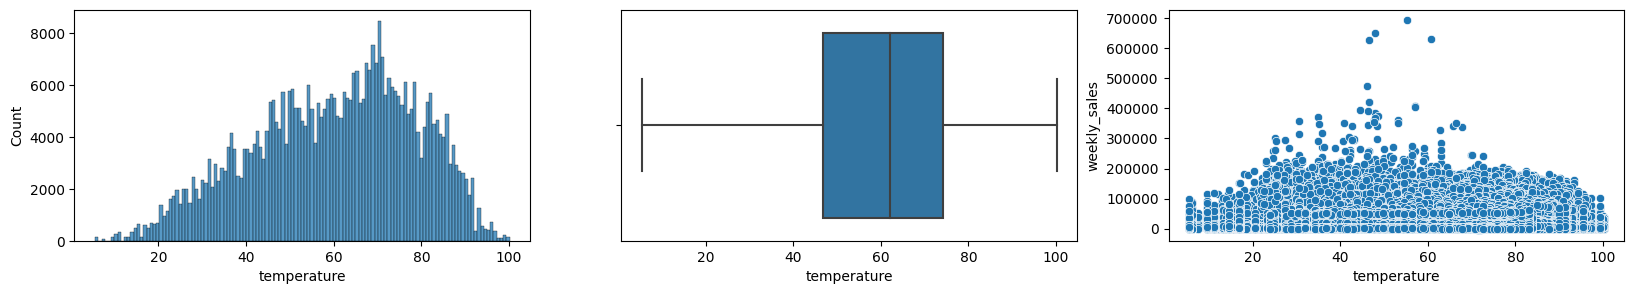

In [33]:
temp = search_outliers(df, 'temperature')
plot_descriptive_statistical(temp, 'temperature')

temp = descriptive_statistical(df, 'temperature')
temp.T

### 1.9.2 Categorical Attributes

# .0 Exploratory Data Analysis

# .0 Feature Engineering

In [22]:
df = df.groupby(['store', 'date']).agg({'weekly_sales':'sum', 'isholiday':'first', 'temperature':'first', 'fuel_price':'first', 'cpi':'first', 'unemployment':'first', 'type':'first', 'size':'first'}).reset_index()
df_raw = df.groupby(['store', 'date']).agg({'weekly_sales':'sum', 'isholiday':'first', 'temperature':'first', 'fuel_price':'first', 'cpi':'first', 'unemployment':'first', 'type':'first', 'size':'first'}).reset_index()

In [23]:
df_raw.head()

,store,date,weekly_sales,isholiday,temperature,fuel_price,cpi,unemployment,type,size
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106,0,151315
1,1,2010-02-12,1641957.44,1,38.51,2.548,211.242170,8.106,0,151315
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106,0,151315
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106,0,151315
4,1,2010-03-05,1554806.68,0,46.50,2.625,211.350143,8.106,0,151315


# .0 Data Preparation

## Target

In [24]:
pp_weekly_sales = pp.MinMaxScaler()
pp_weekly_sales = pp_weekly_sales.fit(df[['weekly_sales']].values)
df['weekly_sales'] = pp_weekly_sales.transform(df[['weekly_sales']].values)

## Features

### Categorical Attributes

In [25]:
# 'isholiday',
map_isholiday = df.groupby('isholiday').agg({'weekly_sales':'mean'})['weekly_sales'] # target encoding
df['isholiday'] = df['isholiday'].map(map_isholiday)

# 'type',
map_type = df.groupby('type').agg({'weekly_sales':'mean'})['weekly_sales'] # target encoding
df['type'] = df['type'].map(map_type)

### Numerical Attributes

In [26]:
# 'temperature',
pp_temperature = pp.MinMaxScaler()
pp_temperature = pp_temperature.fit(df[['temperature']].values)
df['temperature'] = pp_temperature.transform(df[['temperature']].values)

# 'fuel_price',
pp_fuel_price = pp.MinMaxScaler()
pp_fuel_price = pp_fuel_price.fit(df[['fuel_price']].values)
df['fuel_price'] = pp_fuel_price.transform(df[['fuel_price']].values)

# 'cpi',
pp_cpi = pp.MinMaxScaler()
pp_cpi = pp_cpi.fit(df[['cpi']].values)
df['cpi'] = pp_cpi.transform(df[['cpi']].values)

# 'unemployment',
pp_unemployment = pp.MinMaxScaler()
pp_unemployment = pp_unemployment.fit(df[['unemployment']].values)
df['unemployment'] = pp_unemployment.transform(df[['unemployment']].values)

# 'size']
pp_size = pp.MinMaxScaler()
pp_size = pp_size.fit(df[['size']].values)
df['size'] = pp_size.transform(df[['size']].values)

## Splits

In [27]:
train = df[df['date'] < df['date'].max() - pd.Timedelta(6, 'w')]
test = df[df['date'] >= df['date'].max() - pd.Timedelta(6, 'w')]

In [28]:
X_train = train.drop(['date', 'weekly_sales', 'store'], axis=1)
y_train = train['weekly_sales']

X_train_array = X_train.values
y_train_array = np.array(y_train).reshape(-1, 1)

In [29]:
X_test = test.drop(['date', 'weekly_sales', 'store'], axis=1)
y_test = test['weekly_sales']

X_test_array = X_test.values
y_test_array = np.array(y_test).reshape(-1, 1)

# .0 ML Modeling

## Linear Regression

In [30]:
lr_model = LinearRegression()
lr_model = lr_model.fit(X_train, y_train)
predicts = lr_model.predict(X_test)

test['predicts'] = predicts
test['absolute_error'] = np.abs(test['predicts'] - test['weekly_sales'])
mae = test['absolute_error'].mean()
test['proportional_absolute_error'] = test['absolute_error'] / test['weekly_sales']
mape = test['proportional_absolute_error'].mean()

mape

/tmp/ipykernel_16251/478003382.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['predicts'] = predicts
/tmp/ipykernel_16251/478003382.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['absolute_error'] = np.abs(test['predicts'] - test['weekly_sales'])
/tmp/ipykernel_16251/478003382.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata

0.3951442206249105

## Random Forest

In [31]:
rf_model = RandomForestRegressor(max_depth=7)
rf_model = rf_model.fit(X_train, y_train)
predicts = rf_model.predict(X_test)

test['predicts'] = predicts
test['absolute_error'] = np.abs(test['predicts'] - test['weekly_sales'])
mae = test['absolute_error'].mean()
test['proportional_absolute_error'] = test['absolute_error'] / test['weekly_sales']
mape = test['proportional_absolute_error'].mean()

mape

/tmp/ipykernel_16251/1417689200.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['predicts'] = predicts
/tmp/ipykernel_16251/1417689200.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['absolute_error'] = np.abs(test['predicts'] - test['weekly_sales'])
/tmp/ipykernel_16251/1417689200.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyd

0.1515314808717979

## XGBoost Regressor

In [32]:
xgb_model = XGBRegressor(max_depth=7)
xgb_model = xgb_model.fit(X_train, y_train)
predicts = xgb_model.predict(X_test)

test['predicts'] = predicts
test['absolute_error'] = np.abs(test['predicts'] - test['weekly_sales'])
mae = test['absolute_error'].mean()
test['proportional_absolute_error'] = test['absolute_error'] / test['weekly_sales']
mape = test['proportional_absolute_error'].mean()

mape

/tmp/ipykernel_16251/56048586.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['predicts'] = predicts
/tmp/ipykernel_16251/56048586.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['absolute_error'] = np.abs(test['predicts'] - test['weekly_sales'])
/tmp/ipykernel_16251/56048586.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.or

0.13032780535369384

## Best model

In [33]:
model = xgb_model

# .0 Exports

In [34]:
pkl.dump(model, open('../src/models/model.pkl', 'wb'))

In [49]:
# pp_weekly_sales
pkl.dump(pp_weekly_sales, open('../src/features/pp_weekly_sales.pkl', 'wb'))
# map_isholiday
pkl.dump(map_isholiday, open('../src/features/map_isholiday.pkl', 'wb'))
# map_type
pkl.dump(map_type, open('../src/features/map_type.pkl', 'wb'))
# pp_temperature
pkl.dump(pp_temperature, open('../src/features/pp_temperature.pkl', 'wb'))
# pp_cpi
pkl.dump(pp_cpi, open('../src/features/pp_cpi.pkl', 'wb'))
# pp_fuel_price
pkl.dump(pp_fuel_price, open('../src/features/pp_fuel_price.pkl', 'wb'))
# pp_unemployment
pkl.dump(pp_unemployment, open('../src/features/pp_unemployment.pkl', 'wb'))
# pp_size
pkl.dump(pp_size, open('../src/features/pp_size.pkl', 'wb'))

# .0 API

## API Request

In [50]:
# data = X_train.sample(500).to_json(orient='records')
data = df_raw.to_json(orient='records', date_format='iso')
url = 'http://192.168.0.20:5000/predict'
header = {'Content-type':'application/json'}

df_request = requests.post(data=data, headers=header, url=url)
print(df_request.status_code)

df_request = pd.DataFrame(df_request.json(), columns=df_request.json()[0].keys())
df_request['date'] = pd.to_datetime(df_request['date'])
df_request.head()

200


,store,date,weekly_sales,isholiday,temperature,fuel_price,cpi,unemployment,type,size,predicts
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106,0,151315,906266.1875
1,1,2010-02-12,1641957.44,1,38.51,2.548,211.242170,8.106,0,151315,883700.9375
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106,0,151315,815290.5000
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106,0,151315,703740.3125
4,1,2010-03-05,1554806.68,0,46.50,2.625,211.350143,8.106,0,151315,762490.0625


In [58]:
df_request['absolute_error'] =  np.abs(df_request['weekly_sales'] - df_request['predicts'])
mae = df_request['absolute_error'].mean()
df['percentage_absolute_error'] = df_request['absolute_error'] / df_request['weekly_sales']
mape = df['percentage_absolute_error'].mean()
mape

0.10128479129101794